使用SSD检测皮卡丘数据集
===

# 1.SSD简单介绍

![images](images/02_02_002.svg)

上图描述了单发多框检测模型的设计。它主要由一个**基础网络块**和若干个**多尺度特征块**串联而成。其中**基础网络块用来从原始图像中抽取特征**，因此一般会选择常用的深度卷积神经网络。单发多框检测论文中选用了在分类层之前截断的VGG，现在也常用ResNet替代。我们可以设计基础网络，使它输出的高和宽较大。这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。如此一来，图中越靠近顶部的多尺度特征块输出的特征图越小，故而基于特征图生成的锚框也越少，加之特征图中每个单元感受野越大，因此更适合检测尺寸较大的目标。由于单发多框检测基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量（即预测边界框）检测不同大小的目标，因此单发多框检测是一个多尺度的目标检测模型。

# 2.下载数据集

In [2]:
import matplotlib
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, image, autograd, contrib, init, nd
from mxnet.gluon import utils as gutils
from mxnet.gluon import loss as gloss, nn
import os
import time

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

In [3]:
def load_data_pikachu(data_dir,batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # 输出图像的形状
        shuffle=True,  # 以随机顺序读取数据集
        rand_crop=1,  # 随机裁剪的概率为1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

In [4]:
batch_size, edge_size = 32, 256
data_dir = 'data/pikachu'
train_iter, _ = load_data_pikachu(data_dir, batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

# 3.图示数据

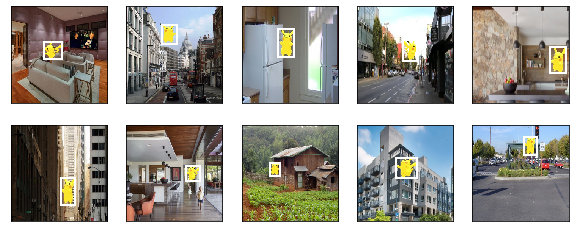

In [5]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# 4.类别预测层

In [6]:
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

# 5.边框预测层

In [7]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

# 6.连结多尺度的预测

In [8]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [9]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

In [10]:
concat_preds([Y1, Y2]).shape

(2, 25300)

# 7.高和宽减半块

In [11]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

In [12]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

# 8.基础网络块

In [13]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

# 9.完整网络

In [14]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [15]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [16]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

写出TinySSD

In [17]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # 即赋值语句self.blk_i = get_blk(i)
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors,
                                                      num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i],
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
        # reshape函数中的0表示保持批量大小不变
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape(
                    (0, -1, self.num_classes + 1)), concat_preds(bbox_preds))

In [18]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


# 10.训练模型

## 10.1.读取数据集合

In [19]:
batch_size = 32
train_iter, _ = load_data_pikachu(data_dir, batch_size)

In [3]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})

NameError: name 'd2l' is not defined

## 10.2.定义损失函数和评价函数

In [1]:
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox
    
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

In [2]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

NameError: name 'gloss' is not defined

## 10.3.训练

In [36]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size
    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

*
*
*
*
*


KeyboardInterrupt: 

# 11.预测目标

In [ ]:
img = image.imread('data/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

In [ ]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

In [ ]:
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)